In [1]:
import boto3
import os 
os.chdir('../')

In [2]:
from utils.load_session import load_session
credential,session=load_session()

# AWS `textrect` Service

`textrect` is a AWS service to extract text and data from scanned documents. Its functionality is similar to `OCR` but goes beyond that. `textract` also identify the contents of fields in forms and information.

In [3]:
s3_client=session.client('s3')

In [4]:
##name of existing clients
for bucket in s3_client.list_buckets()['Buckets']:
    Bucket=bucket['Name']
    print('Name of Bucket:',Bucket)

Name of Bucket: akashghimireofficial


In [5]:
## uploading files in s3_client . We will upload Document to be used here

from glob import glob 
from os.path import basename,join
from os import makedirs

In [6]:
document_filenames=glob(join('data','images','ocr_test','*'))

for doc_filename in document_filenames:
    key_filename=join('images','ocr_test',basename(doc_filename))
    s3_client.upload_file(Filename=doc_filename,Bucket=Bucket,Key=key_filename)

In [7]:
keys=[]
for content in s3_client.list_objects_v2(Bucket=Bucket,Prefix='images/ocr_test/')['Contents']:
    keys.append(content['Key'])
    
print(keys)

['images/ocr_test/001.jpg', 'images/ocr_test/002.jpg', 'images/ocr_test/003.jpg', 'images/ocr_test/004.jpg', 'images/ocr_test/005.jpg', 'images/ocr_test/006.jpg', 'images/ocr_test/cheque.jpg']


## Some important methods in `textract_session`

1. `.detect_document_text()`: Detects text in a document stored in an S3 bucket or provided as base64-encoded bytes.
2. `.analyze_document()`: Extracts text, forms, and tables from a document stored in an S3 bucket or provided as base64-encoded bytes.

## Common and main parameters in above methods

1. `Document` (**dict**): Specifies the input document either as base64-encoded bytes or as an S3 object.

    `Document` has two **Sub-parameters**:

    - `Bytes` (**bytes**): Document bytes object encoded as base64 data. Must encode to bytes.
    
    - `S3Object` (**dict**): Document file stored in an S3 bucket. It takes two parameters:
        - `Bucket` (**string**): The name of the S3 bucket.
        - `Name` (**string**): The key of the document in the S3 bucket.

2. `FeatureTypes` (**list**) ***Required for `analyze_document` method***: Specifies the types of analysis to perform. Valid values are `["TABLES", "FORMS"]`. 


## Key Difference Between `analyze_document` and `detect_document_text`

### `detect_document_text`

- **Purpose**: This method is used to detect and extract raw text from a document.
- **Use Case**: It is suitable for scenarios where you only need to retrieve the text content of a document without any structural or contextual information.
- **Output**: Returns blocks of text as lines, words, and their bounding boxes, but does not provide any information about forms, tables, or key-value pairs.
- **Common Parameters**:
  - `Document`: Specifies the input document either as base64-encoded bytes or as an S3 object.

### `analyze_document`

- **Purpose**: This method is used to analyze and extract text along with the structure of the document, such as forms and tables.
- **Use Case**: It is suitable for scenarios where you need to understand the layout and context of the document, such as extracting data from forms, detecting tables, and understanding the relationships between different elements.
- **Output**: Returns blocks of text with additional information about their roles (e.g., key-value pairs in forms, table cells) and their relationships.
- **Common Parameters**:
  - `Document`: Specifies the input document either as base64-encoded bytes or as an S3 object.
  - `FeatureTypes`: Specifies the types of analysis to perform, such as `["TABLES", "FORMS"]`.

### Detailed Explanation

#### `detect_document_text` Example

The `detect_document_text` method focuses on extracting text without considering the structure of the document.

```python
import boto3

# Initialize the Textract client
textract_client = boto3.client('textract', region_name='ap-southeast-2')

# Define the S3 bucket and document key
bucket_name = 'my-unique-bucket-name'
document_key = 'path/to/document.jpg'

# Call the detect_document_text method
response = textract_client.detect_document_text(
    Document={
        'S3Object': {
            'Bucket': bucket_name,
            'Name': document_key
        }
    }
)

# Process the response
print("Detected text in the document:")
for item in response['Blocks']:
    if item['BlockType'] == 'LINE':
        print(f"{item['Text']} (Confidence: {item['Confidence']:.2f}%)")


In [9]:
textract_client=session.client('textract')

`.detect_document_text()`

In [10]:
response=textract_client.detect_document_text(
    Document={
        'S3Object':
        {
            'Bucket':Bucket,
            'Name': keys[0]
        }
    }
)

In [11]:
response.keys()

dict_keys(['DocumentMetadata', 'Blocks', 'DetectDocumentTextModelVersion', 'ResponseMetadata'])

In [12]:
for block in response['Blocks']:
    print('BlockType: ',block['BlockType'])
    if block['BlockType'] !='PAGE':
        print('Text: ',block['Text'])
    
    

BlockType:  PAGE
BlockType:  LINE
Text:  Response ID
BlockType:  LINE
Text:  590
BlockType:  LINE
Text:  Notes
BlockType:  LINE
Text:  I liked every thing from the first
BlockType:  LINE
Text:  scene
BlockType:  WORD
Text:  Response
BlockType:  WORD
Text:  ID
BlockType:  WORD
Text:  590
BlockType:  WORD
Text:  Notes
BlockType:  WORD
Text:  I
BlockType:  WORD
Text:  liked
BlockType:  WORD
Text:  every
BlockType:  WORD
Text:  thing
BlockType:  WORD
Text:  from
BlockType:  WORD
Text:  the
BlockType:  WORD
Text:  first
BlockType:  WORD
Text:  scene


``.analyze_document()``

In [13]:
response=textract_client.analyze_document(
    Document=
    {
        'S3Object':{
            'Bucket':Bucket,
            'Name':keys[0]
        }
        
    },
    FeatureTypes=['TABLES']
)

In [47]:
response

{'DocumentMetadata': {'Pages': 1},
 'Blocks': [{'BlockType': 'PAGE',
   'Geometry': {'BoundingBox': {'Width': 1.0,
     'Height': 1.0,
     'Left': 0.0,
     'Top': 0.0},
    'Polygon': [{'X': 0.0, 'Y': 1.0445430120853416e-07},
     {'X': 1.0, 'Y': 0.0},
     {'X': 1.0, 'Y': 1.0},
     {'X': 0.0, 'Y': 1.0}]},
   'Id': '00320281-46f3-40fe-ae2b-3ad48f51fc6f',
   'Relationships': [{'Type': 'CHILD',
     'Ids': ['ed4202c2-e986-440a-a60d-474615fff31d',
      'b6484f85-586c-4ab8-bfff-505a81d2edda',
      '12c0d9cc-302b-41e9-b991-7f8bf6e09c70',
      'aaaceb88-a91e-4444-8f43-9cc826861dd8',
      '7c7396f0-0654-4d56-9918-f5c364fa047f']}]},
  {'BlockType': 'LINE',
   'Confidence': 99.8954849243164,
   'Text': 'Response ID',
   'Geometry': {'BoundingBox': {'Width': 0.0989999920129776,
     'Height': 0.013172810897231102,
     'Left': 0.12449004501104355,
     'Top': 0.08601831644773483},
    'Polygon': [{'X': 0.12449190020561218, 'Y': 0.08608762174844742},
     {'X': 0.22349004447460175, 'Y': 0.

In [14]:
response.keys()

dict_keys(['DocumentMetadata', 'Blocks', 'AnalyzeDocumentModelVersion', 'ResponseMetadata'])

In [15]:
response['Blocks'][1]

{'BlockType': 'LINE',
 'Confidence': 99.8954849243164,
 'Text': 'Response ID',
 'Geometry': {'BoundingBox': {'Width': 0.0989999920129776,
   'Height': 0.013172810897231102,
   'Left': 0.12449004501104355,
   'Top': 0.08601831644773483},
  'Polygon': [{'X': 0.12449190020561218, 'Y': 0.08608762174844742},
   {'X': 0.22349004447460175, 'Y': 0.08601831644773483},
   {'X': 0.22348883748054504, 'Y': 0.09912172704935074},
   {'X': 0.12449004501104355, 'Y': 0.09919112920761108}]},
 'Id': 'e88aeb4d-18e3-4f13-ac8b-d3742fbbe671',
 'Relationships': [{'Type': 'CHILD',
   'Ids': ['7c7f8314-7330-4e34-8497-fe31673d9a52',
    '60bdce08-37d3-4e41-8cab-5ab00180d2ba']}]}

In [16]:
for block in response['Blocks']:
    print('BlockType: ',block['BlockType'])
    if block['BlockType'] =='TABLE':
        print('Text: ',block['Text'])
    
    

BlockType:  PAGE
BlockType:  LINE
BlockType:  LINE
BlockType:  LINE
BlockType:  LINE
BlockType:  LINE
BlockType:  WORD
BlockType:  WORD
BlockType:  WORD
BlockType:  WORD
BlockType:  WORD
BlockType:  WORD
BlockType:  WORD
BlockType:  WORD
BlockType:  WORD
BlockType:  WORD
BlockType:  WORD
BlockType:  WORD


## Analysing Cheques 

In [21]:
import matplotlib.pyplot as plt 
from utils.utils import BGR2RGB
import cv2


In [22]:
cheque_img_dire='data/images/ocr_test/cheque.jpg'
img=cv2.imread(cheque_img_dire)



In [24]:
with open(cheque_img_dire,'rb') as f:
    img_byte=f.read()

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\xff\xdb\x00C\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\xff\xc0\x00\x11\x08\x04L\t=\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x1

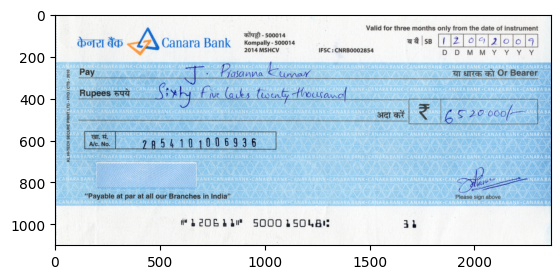

In [23]:
plt.imshow(BGR2RGB(img))

In [31]:
response=textract_client.analyze_document(
    Document=
    {
        'Bytes':img_byte
    }
    ,
    FeatureTypes=['FORMS']
)

In [32]:
response

{'DocumentMetadata': {'Pages': 1},
 'Blocks': [{'BlockType': 'PAGE',
   'Geometry': {'BoundingBox': {'Width': 1.0,
     'Height': 1.0,
     'Left': 0.0,
     'Top': 0.0},
    'Polygon': [{'X': 0.0, 'Y': 5.5670678733577006e-08},
     {'X': 1.0, 'Y': 0.0},
     {'X': 1.0, 'Y': 1.0},
     {'X': 0.0, 'Y': 1.0}]},
   'Id': '994fb3f6-0e02-484d-b880-722931f2c382',
   'Relationships': [{'Type': 'CHILD',
     'Ids': ['50e7a37e-266b-49fe-9052-f31a009ceccd',
      '99dfbe34-0995-44ae-931f-95d6825e930f',
      '899f79d0-ae74-4df8-878e-028a7bac0509',
      'ccecf7e1-e04d-48ca-bcb7-708925135e1c',
      '649b1098-0d59-4be7-9184-4984d0dda0d1',
      'e894e04f-020b-4a78-83aa-e355e2a23a62',
      'b316456d-4849-4907-a4ff-deae1828dcbe',
      '6008ed5c-ab96-4b0c-a42c-1e1843a93d2b',
      '376eb6d5-5aed-4b7d-985e-17cbc0594268',
      '73551177-1a65-4b40-98d2-dadf2ac67d8c',
      '76209e5c-c74a-487e-8bba-16904b8b042e',
      '42df3792-f916-4d5f-b70f-2211e6f5810b',
      '1d235407-eed6-42af-bcbb-0a8f816497c